# Granovetter Threshold Model — Targeting for Maximum Spread

## 1. Setup

In [1]:

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
from time import time

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.dpi'] = 120

print("Packages loaded.")


Packages loaded.


## 2. Configuration

In [3]:
# Parameters
N = 300 # Number of nodes
k_avg = 6 # Average degree we aim for
B = 5 # Number of initial adopters
ENSEMBLES = 10 # Number of ensemble simulations to run
RUNS_PER_SETTING = 15 # Number of simulation runs for each threshold setting

# Threshold mode, defines how the threshold is set for each node
THRESHOLD_MODE = 'beta'   # 'uniform', 'beta', 'constant', 'normal'
PHI_MEAN = 0.30
PHI_STD = 0.10

# Maximum number of steps in each simulation run
MAX_STEPS = 200
# Number of steps to run the greedy algorithm for
GREEDY_R = 5

print(f"N={N}, k_avg={k_avg}, B={B}, ENSEMBLES={ENSEMBLES}, RUNS_PER_SETTING={RUNS_PER_SETTING}")


N=300, k_avg=6, B=5, ENSEMBLES=10, RUNS_PER_SETTING=15


## 3. Network Generators

In [4]:

# This function builds three different types of networks: Erdős-Rényi (ER), Watts-Strogatz (WS), and Barabási-Albert (BA)
# Each network is generated with a specified number of nodes (N) and average degree (k_avg)
# The seed_base parameter is used to ensure different random networks are generated each time the function is called
def build_networks(N, k_avg, seed_base=0):
    p_er = k_avg / (N - 1)
    G_er = nx.erdos_renyi_graph(N, p_er, seed=seed_base + 1)

    k_ws = max(2, int(round(k_avg)))
    if k_ws % 2 == 1:
        k_ws += 1
    p_ws = 0.1
    G_ws = nx.watts_strogatz_graph(N, k_ws, p_ws, seed=seed_base + 2)

    m_ba = max(1, int(k_avg // 2))
    G_ba = nx.barabasi_albert_graph(N, m_ba, seed=seed_base + 3)

    return {'ER': G_er, 'WS': G_ws, 'BA': G_ba}

graphs = build_networks(N, k_avg, seed_base=RANDOM_SEED)
{name: (G.number_of_nodes(), G.number_of_edges()) for name, G in graphs.items()}


{'ER': (300, 858), 'WS': (300, 900), 'BA': (300, 891)}

## 4. Threshold Distributions

In [5]:

# This function draws threshold values for each node in the graph G
# The threshold mode determines how the threshold values are generated
# Each node samples a threshold value from a specified distribution (defined by mode)
# The phi_mean and phi_std parameters are used to control the mean and standard deviation of the normal distribution
def draw_thresholds(G, mode='uniform', phi_mean=0.3, phi_std=0.1):
    if mode == 'uniform':
        return {n: np.random.uniform(0, 1) for n in G}
    if mode == 'beta':
        a, b = 2, 5
        return {n: np.random.beta(a, b) for n in G}
    if mode == 'constant':
        return {n: float(phi_mean) for n in G}
    if mode == 'normal':
        vals = np.clip(np.random.normal(phi_mean, phi_std, len(G)), 0, 1)
        return {n: float(vals[i]) for i, n in enumerate(G)}
    raise ValueError(f"Unknown threshold mode: {mode}")

# This loop iterates over each graph in the graphs dictionary
# For each graph, it draws threshold values using the draw_thresholds function
# It then calculates the mean of these threshold values and prints it
for name, G in graphs.items():
    th = draw_thresholds(G, mode=THRESHOLD_MODE, phi_mean=PHI_MEAN, phi_std=PHI_STD)
    arr = np.array(list(th.values()))
    print(name, "threshold mean:", round(arr.mean(), 3))


ER threshold mean: 0.276
WS threshold mean: 0.298
BA threshold mean: 0.28


## 5. Threshold Dynamics

In [ ]:

# This function simulates the threshold dynamics on a graph G
# The function takes as input the graph G, a list of seed nodes (seeds), a dictionary of threshold values (thresholds), and the maximum number of steps (max_steps)
# The function returns a dictionary of adopted nodes (adopted) and a numpy array of the fraction of adopted nodes over time (history)
def threshold_dynamics(G, seeds, thresholds, max_steps=100):
    adopted = {n: 0 for n in G}
    for s in seeds:
        adopted[s] = 1 # initially, all seed nodes are adopted

    history = [sum(adopted.values()) / len(G)] #the history will store the fraction of adopted nodes over time, initially it is the fraction of adopted seed nodes

    for _ in range(max_steps): # iterate max_steps times
        new_adopted = adopted.copy()
        changed = False
        for i in G: # iterate over all nodes i in the graph G
            if adopted[i] == 0: # if node i is not adopted yet
                neigh = list(G.neighbors(i))
                if not neigh: # if node i has no neighbors, skip it
                    continue
                frac = sum(adopted[j] for j in neigh) / len(neigh) # calculate the fraction of adopted neighbors of node i
                if frac >= thresholds[i]: # if the fraction of adopted neighbors is greater than or equal to the threshold of node i
                    new_adopted[i] = 1 # adopt node i
                    changed = True
        #-- end of one iteration

        # update the adopted nodes after checking all nodes
        adopted = new_adopted
        history.append(sum(adopted.values()) / len(G)) #add the total adopted this timestep to the history
        if not changed:
            break # if no node is adopted in this iteration, break the loop (no more adoptions so we can stop)

    return adopted, np.array(history)



## 6. Measurement Utilities

In [ ]:

def final_adoption_fraction(adopted):
    return sum(adopted.values()) / len(adopted)

# function to calculate the time to reach a target fraction of adopted nodes
def time_to_fraction(history, target=0.5):
    idx = np.where(history >= target)[0]
    return float(idx[0]) if len(idx) else np.nan




## 7. Seeding Strategies — Heuristics

In [ ]:

def random_seeds(G, B):
    return random.sample(list(G.nodes()), B)

def high_degree_seeds(G, B):
    """
    Select the top-B nodes with the highest degree in graph G.
    """
    # Get all (node, degree) pairs
    degree_list = list(G.degree())

    # Sort nodes by degree in descending order
    sorted_by_degree = sorted(degree_list, key=lambda x: x[1], reverse=True)

    # Take the top-B entries
    top_B = sorted_by_degree[:B]

    # Extract only the node IDs
    result = []
    for n, d in top_B:
        result.append(n)

    return result


#This code below does the same as for degree. It uses a list comprehension and a lambda function.
# The lambda function takes a tuple x = (n, b) and returns the second element (b), which is the betweenness centrality of node n.]
# sorted(bc.items(), key=lambda x: x[1], reverse=True) sorts the items of the dictionary bc.items() by the value of the betweenness centrality (x[1]) in descending order. (Highest first)
# [:B] takes the first B entries from the sorted list, which are the nodes with the highest betweenness centrality.
def betweenness_seeds(G, B):
    bc = nx.betweenness_centrality(G) #returns a dictionary that maps each node to its betweenness centrality. {n_1: bc(n_1), n_2: bc(n_2), ...}
    return [n for n, _ in sorted(bc.items(), key=lambda x: x[1], reverse=True)[:B]]


# This function seeds the network with B nodes with the highest core number, the core number is the number of nodes that are connected to all its neighbors
# For a given graph G, the core number of a node v is the largest integer k such that v belongs to the k-core of G.
# In other words:
# 	•	It tells you how deeply embedded a node is within the dense core structure of the network.
# 	•	A higher core number means the node is part of a more cohesive and connected region of the graph.
def kcore_seeds(G, B):
    core = nx.core_number(G) #core_number is a dictionary that maps each node to its core number. 
    return [n for n, _ in sorted(core.items(), key=lambda x: x[1], reverse=True)[:B]]



## 8. Spread Estimation

In [ ]:

# This function estimates the spread of the threshold dynamics on graph G
# It runs the threshold dynamics R times with different random seeds and thresholds
# and returns the average final adoption fraction
def estimate_spread(G, seeds, thresholds, R=5, max_steps=100):
    results = []
    for _ in range(R):
        adopted, _ = threshold_dynamics(G, seeds, thresholds, max_steps=max_steps)
        results.append(final_adoption_fraction(adopted))
    return float(np.mean(results))



## 9. Greedy Marginal Gain (CELF-like)

In [10]:

def greedy_celf(G, B, thresholds, R=5, max_steps=100, verbose=False):
    """
    CELF-like lazy greedy influence maximization.
    Uses submodularity to reduce marginal gain recomputations.
    Returns: list of selected seed nodes (length B)
    """
    base_current = estimate_spread(G, [], thresholds, R=1, max_steps=max_steps)

    PQ = [] # priority queue, store the seed nodes with their gains (their impact on final adoption when they are added to the seed set)
    for v in G:
        gain_v = estimate_spread(G, [v], thresholds, R=R, max_steps=max_steps) - base_current
        PQ.append({'v': v, 'gain': gain_v, 'updated_at': -1})
    PQ.sort(key=lambda d: d['gain'], reverse=True)

    S = [] # selected seed nodes
    k = 0 # current iteration number
    while len(S) < B and PQ: # while we have not selected B seed nodes and the priority queue is not empty
        top = PQ.pop(0) # pop the node with the highest gain, first in PQ
        v = top['v']
        if top['updated_at'] == k: # if the node v is  updated in the current iteration
            S.append(v) # add the node v to the seed set
            k += 1 # update the current iteration number
            base_current = estimate_spread(G, S, thresholds, R=1, max_steps=max_steps) # update the current spread of the threshold dynamics
            if verbose:
                print(f"Accepted {v} with gain ~ {top['gain']:.4f}. |S|={len(S)}")
        else: # if the node v is not updated in the current iteration
            gain_true = estimate_spread(G, S + [v], thresholds, R=R, max_steps=max_steps) - base_current # compute the true gain of adding v to the seed set
            top['gain'] = gain_true
            top['updated_at'] = k
            PQ.append(top) # add the node v to the priority queue with its updated gain
            PQ.sort(key=lambda d: d['gain'], reverse=True) # sort the priority queue by the gain in descending order

    return S


## 10. Experiment Runner

In [ ]:

def run_experiments(N, k_avg, ensembles=5, runs_per_setting=10, threshold_mode='beta',
                    phi_mean=0.3, phi_std=0.1, B=5, max_steps=200, greedy_R=5):
    import numpy as _np
    import pandas as _pd
    from time import time as _time
    results = []
    t0 = _time()
    for e in range(ensembles): # for each ensemble
        graphs = build_networks(N, k_avg, seed_base=RANDOM_SEED + e * 10) # build the networks
        for name, G in graphs.items(): # for each network
            thresholds = draw_thresholds(G, mode=threshold_mode, phi_mean=phi_mean, phi_std=phi_std) # draw the thresholds for each node from the distribution specified by threshold_mode

            strategies = { #dictionary of seed selection strategies, the value is a (lamba) function that returns the seed set for the current strategy
                'Random': lambda: random_seeds(G, B),
                'Degree': lambda: high_degree_seeds(G, B),
                'K-core': lambda: kcore_seeds(G, B),
                'Betweenness': lambda: betweenness_seeds(G, B),
                'Greedy': lambda: greedy_celf(G, B, thresholds, R=greedy_R, max_steps=max_steps, verbose=False)
            }

            for strat, seed_fn in strategies.items(): # for each seed selection strategy
                seeds = seed_fn() # get the seed set for the current strategy
                final_sizes, t50_list = [], []
                for _ in range(runs_per_setting):
                    adopted, history = threshold_dynamics(G, seeds, thresholds, max_steps=max_steps)
                    final_sizes.append(final_adoption_fraction(adopted))
                    t50_list.append(time_to_fraction(history, target=0.5))
                results.append({
                    'Ensemble': e,
                    'Network': name,
                    'Strategy': strat,
                    'FinalAdoption': float(_np.mean(final_sizes)),
                    'CascadeProb': float(_np.mean(_np.array(final_sizes) >= 0.5)),
                    'Time50': float(_np.nanmean(t50_list)),
                    'Efficiency': float(_np.mean(final_sizes) / B),
                    'Seeds': seeds
                })
    t1 = _time()
    print(f"Completed {ensembles} ensembles x 3 networks x 5 strategies in {t1 - t0:.1f}s")
    return _pd.DataFrame(results)



## 11. Run the full experiment

In [12]:

df_results = run_experiments(
    N=N,
    k_avg=k_avg,
    ensembles=ENSEMBLES,
    runs_per_setting=RUNS_PER_SETTING,
    threshold_mode=THRESHOLD_MODE,
    phi_mean=PHI_MEAN,
    phi_std=PHI_STD,
    B=B,
    max_steps=MAX_STEPS,
    greedy_R=GREEDY_R
)
df_results.head()


C:\Users\binti\AppData\Local\Temp\ipykernel_42328\1649635361.py:34: RuntimeWarning: Mean of empty slice
  'Time50': float(_np.nanmean(t50_list)),


Completed 10 ensembles x 3 networks x 5 strategies in 1149.8s


,Ensemble,Network,Strategy,FinalAdoption,CascadeProb,Time50,Efficiency,Seeds
0,0,ER,Random,0.99,1.0,9.0,0.198,"[57, 12, 140, 125, 114]"
1,0,ER,Degree,0.99,1.0,5.0,0.198,"[232, 244, 85, 76, 14]"
2,0,ER,K-core,0.99,1.0,7.0,0.198,"[1, 2, 3, 4, 5]"
3,0,ER,Betweenness,0.99,1.0,5.0,0.198,"[232, 244, 85, 47, 76]"
4,0,ER,Greedy,1.00,1.0,19.0,0.200,"[0, 80, 111, 292, 87]"


## 12. Save results to CSV

In [17]:

csv_path = "C:\\Users\\binti\\model_b_decision\\Model-Based-Decisions-Code\\assignment_2\\granovetter_experiment_results.csv"
df_results.to_csv(csv_path, index=False)
print("Saved:", csv_path)


Saved: C:\Users\binti\model_b_decision\Model-Based-Decisions-Code\assignment_2\granovetter_experiment_results.csv


## 13. Summaries and Tables

In [14]:

pivot_final = df_results.pivot_table(index='Strategy', columns='Network', values='FinalAdoption', aggfunc='mean')
pivot_cascade = df_results.pivot_table(index='Strategy', columns='Network', values='CascadeProb', aggfunc='mean')
pivot_eff = df_results.pivot_table(index='Strategy', columns='Network', values='Efficiency', aggfunc='mean')

print("Final adoption (mean):")
display(pivot_final)
print("\nCascade probability (mean):")
display(pivot_cascade)
print("\nEfficiency (mean):")
display(pivot_eff)


Final adoption (mean):


Network,BA,ER,WS
Strategy,,,
Betweenness,1.000000,0.997667,0.964667
Degree,1.000000,0.997667,0.959333
Greedy,1.000000,1.000000,1.000000
K-core,1.000000,0.900667,0.872667
Random,0.719667,0.905667,0.978333



Cascade probability (mean):


Network,BA,ER,WS
Strategy,,,
Betweenness,1.0,1.0,1.0
Degree,1.0,1.0,1.0
Greedy,1.0,1.0,1.0
K-core,1.0,0.9,0.9
Random,0.7,0.9,1.0



Efficiency (mean):


Network,BA,ER,WS
Strategy,,,
Betweenness,0.200000,0.199533,0.192933
Degree,0.200000,0.199533,0.191867
Greedy,0.200000,0.200000,0.200000
K-core,0.200000,0.180133,0.174533
Random,0.143933,0.181133,0.195667


## 14. Visual Comparison

<Figure size 840x480 with 0 Axes>

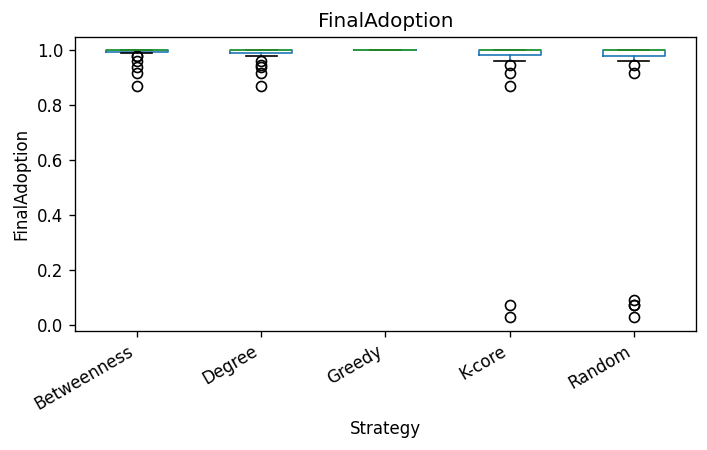

<Figure size 840x480 with 0 Axes>

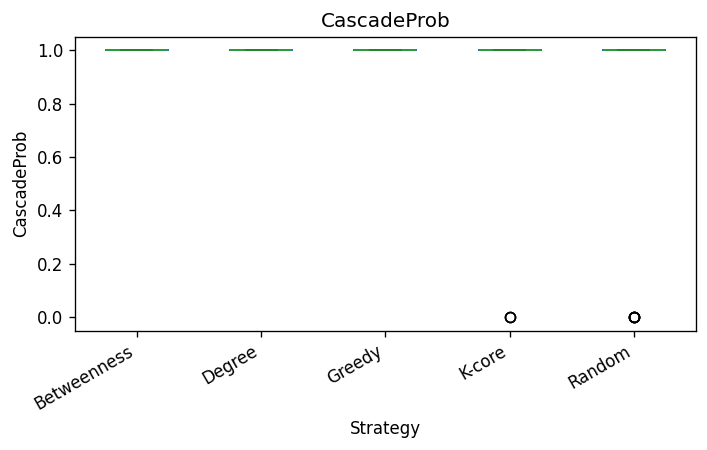

<Figure size 840x480 with 0 Axes>

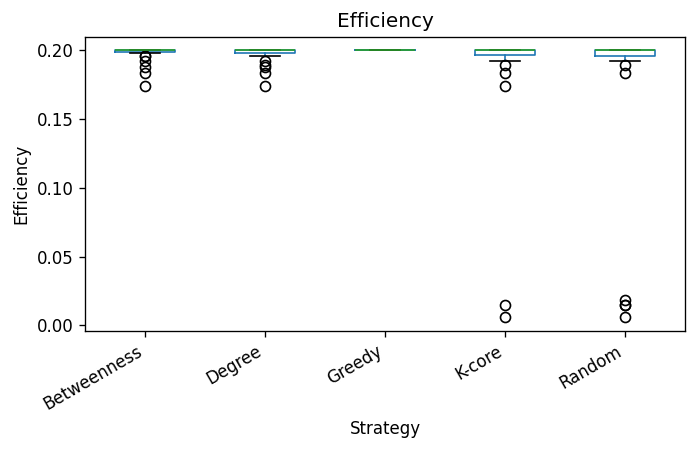

In [15]:

# Separate charts per metric, no seaborn and no explicit colors
metrics = ['FinalAdoption', 'CascadeProb', 'Efficiency']
for metric in metrics:
    plt.figure(figsize=(7,4))
    df_results.boxplot(column=metric, by='Strategy', grid=False)
    plt.title(metric)
    plt.suptitle("")
    plt.xlabel("Strategy")
    plt.ylabel(metric)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()



## 15. Discussion
- Cluster-focused and threshold-aware strategies (k-core, betweenness) often outperform degree targeting at intermediate thresholds by leveraging local reinforcement.
- Bridge targeting can unlock cascades across communities in modular graphs.
- Greedy (CELF-like) tends to yield the best performance for small to medium seed budgets, at higher computational cost, but the lazy updates keep it tractable.
- Adjust `THRESHOLD_MODE`, `B`, `ENSEMBLES`, and `RUNS_PER_SETTING` to trade off runtime versus statistical stability.
